In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [3]:
# Load the diabetes dataset
from sklearn.datasets import load_diabetes
diabetes_dataset = load_diabetes()
print(diabetes_dataset['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
http://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Brad

In [4]:
# Save the input and target variables
#print(diabetes_dataset.keys())
data = diabetes_dataset['data']
targets = diabetes_dataset['target']

In [5]:
# Normalise the target data (this will make clearer training curves)
targets = (targets - targets.mean(axis = 0))/ targets.std()
targets

array([-1.47194752e-02, -1.00165882e+00, -1.44579915e-01,  6.99512942e-01,
       -2.22496178e-01, -7.15965848e-01, -1.83538046e-01, -1.15749134e+00,
       -5.47147277e-01,  2.05006151e+00, -6.64021672e-01, -1.07957508e+00,
        3.48889755e-01,  4.26806019e-01, -4.43258925e-01,  2.45001404e-01,
        1.80071184e-01, -1.05621783e-01, -7.15965848e-01,  2.06043272e-01,
       -1.09256112e+00, -1.33929596e+00, -1.09256112e+00,  1.20596866e+00,
        4.13819975e-01,  6.47568766e-01, -1.96524090e-01, -8.71798376e-01,
       -2.74440354e-01,  1.69943833e+00, -3.00412442e-01, -1.20943552e+00,
        2.45262887e+00, -8.45826288e-01, -1.13151925e+00, -6.51035629e-01,
        1.46568953e+00,  1.60853602e+00,  1.29687096e+00, -8.06868156e-01,
       -6.77007716e-01, -1.26137969e+00, -1.18346343e+00, -7.80896068e-01,
        1.38777327e+00, -1.28735178e+00,  4.91736239e-01, -1.31593871e-01,
       -1.00165882e+00, -1.31593871e-01,  3.72247006e-02,  9.46247777e-01,
       -1.20943552e+00, -

In [6]:
# Split the data into train and test sets

from sklearn.model_selection import train_test_split
train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size = 0.1)

print(train_data.shape)
print(test_data.shape)
print(train_targets.shape)
print(test_targets.shape)

(397, 10)
(45, 10)
(397,)
(45,)


#### Train a feedforward neural network model

In [7]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_model():
    model = Sequential([
        Dense(128, activation = 'relu', input_shape = (train_data.shape[1],)),
        Dense(128, activation = 'relu'),
        Dense(128, activation = 'relu'),
        Dense(128, activation = 'relu'),
        Dense(128, activation = 'relu'),
        Dense(128, activation = 'relu'),
        Dense(1)
        
    ])
    return model
model = get_model()

In [8]:
# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1

In [9]:
# Compile the model
model.compile(optimizer = 'adam', loss = 'mae', metrics = ['mae'])


In [10]:
# Train the model, with some of the data reserved for validation
history = model.fit(train_data, train_targets, epochs = 100, 
                   validation_split = 0.15, batch_size = 64, verbose = False)


In [11]:
# Evaluate the model on the test set
model.evaluate(test_data, test_targets, verbose = 2)


45/1 - 0s - loss: 0.5742 - mae: 0.6631


[0.6631132662296295, 0.6631133]

#### Plot the learning curves

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

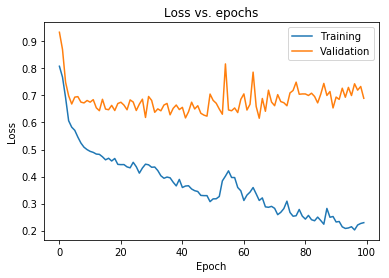

In [13]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [14]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [15]:
def get_regularised_model(wd, rate):
    model = Sequential([
        Dense(128,kernel_regularizer = regularizers.l2(wd), activation="relu", input_shape=(train_data.shape[1],)),
        Dropout(rate),
        Dense(128, activation="relu",kernel_regularizer = regularizers.l2(wd)),
        Dropout(rate),
        Dense(128, activation="relu",kernel_regularizer = regularizers.l2(wd)),
        Dropout(rate),
        Dense(128, activation="relu",kernel_regularizer = regularizers.l2(wd)),
        Dropout(rate),
        Dense(128, activation="relu",kernel_regularizer = regularizers.l2(wd)),
        Dropout(rate),
        Dense(128, activation="relu",kernel_regularizer = regularizers.l2(wd)),
        Dropout(rate),
        Dense(1)
    ])
    return model

In [16]:
# Re-build the model with weight decay and dropout layers
model = get_regularised_model(1e-5, 0.3)


In [17]:
# Compile the model
model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])


In [18]:
# Train the model, with some of the data reserved for validation
model.fit(train_data, train_targets, epochs = 100, validation_split = 0.15, batch_size = 64, verbose = False)

In [19]:
# Evaluate the model on the test set

model.evaluate(test_data, test_targets, verbose = 2)

45/1 - 0s - loss: 0.4996 - mae: 0.5608


[0.5712507367134094, 0.56078327]

#### Plot the learning curves

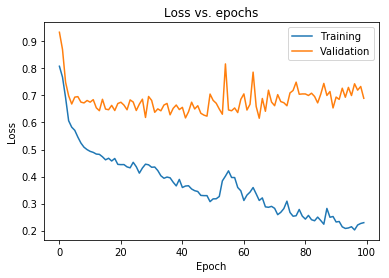

In [20]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [21]:
# Write a custom callback
from tensorflow.keras.callbacks import Callback

class TrainingCallback(Callback):
    def on_train_begin(self, logs = None):
        print("Starting training....")
    def on_epoch_begin(self, epoch, logs = None):
        print(f"Training:Starting epoch {epoch}")
    def on_train_batch_begin(self, batch, logs = None):
        print(f"Training:starting batch{batch}")
    def on_epoch_end(self, epoch, logs = None):
        print(f"Finished epoch{epoch}")
        
    def on_train_end(self, logs = None):
        print("Finished training")
        
class TestingCallback(Callback):
    def on_test_begin(self, logs = None):
        print("Starting testing....")
    def on_test_batch_begin(self, batch, logs = None):
        print(f"Testing:starting batch{batch}")        
    def on_test_end(self, logs = None):
        print("Finished testing")
        
class PredictionCallback(Callback):
    def on_predict_begin(self, logs = None):
        print("Starting testing....")
    def on_predict_batch_begin(self, batch, logs = None):
        print(f"Testing:starting batch{batch}")        
    def on_predict_end(self, logs = None):
        print("Finished testing")

In [22]:
# Re-build the model
model = get_regularised_model(1e-5, 0.3)

In [23]:
# Compile the model

model.compile(optimizer = 'adam', loss = 'mse')

#### Train the model with the callback

In [24]:
# Train the model, with some of the data reserved for validation
model.fit(train_data, train_targets, epochs= 3, batch_size = 128, verbose = False, callbacks = [TrainingCallback()])


Starting training....
Training:Starting epoch 0
Training:starting batch0
Training:starting batch1
Training:starting batch2
Training:starting batch3
Finished epoch0
Training:Starting epoch 1
Training:starting batch0
Training:starting batch1
Training:starting batch2
Training:starting batch3
Finished epoch1
Training:Starting epoch 2
Training:starting batch0
Training:starting batch1
Training:starting batch2
Training:starting batch3
Finished epoch2
Finished training


In [25]:
# Evaluate the model

model.evaluate(test_data, test_targets, verbose = False, callbacks = [TestingCallback()])

Starting testing....
Testing:starting batch0
Testing:starting batch1
Finished testing


1.1407000210550096

In [26]:
# Make predictions with the model
model.predict(test_data, verbose = False, callbacks = [PredictionCallback()])

Starting testing....
Testing:starting batch0
Testing:starting batch1
Finished testing


array([[-0.13370416],
       [ 0.01881421],
       [ 0.06850876],
       [ 0.01247375],
       [-0.14149535],
       [ 0.04398887],
       [-0.06849943],
       [ 0.06915312],
       [-0.01049233],
       [ 0.0666528 ],
       [-0.11025643],
       [ 0.04776195],
       [ 0.05856999],
       [-0.13959636],
       [-0.12148584],
       [-0.10079532],
       [-0.07041802],
       [-0.0197146 ],
       [-0.11912126],
       [-0.1168585 ],
       [ 0.02063878],
       [ 0.02688155],
       [-0.01278071],
       [-0.15353377],
       [-0.01818918],
       [ 0.02978019],
       [-0.16527112],
       [-0.12993567],
       [ 0.04371894],
       [-0.00702397],
       [-0.01005609],
       [-0.03123966],
       [ 0.06762414],
       [ 0.03525519],
       [-0.07584617],
       [ 0.03522086],
       [-0.15994832],
       [-0.12333645],
       [-0.12310817],
       [-0.1445036 ],
       [-0.12867045],
       [-0.0207774 ],
       [ 0.00766055],
       [ 0.04296745],
       [-0.11872043]], dtype=flo

***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [38]:
# Re-train the unregularised model
unregularised_model = get_model()
unregularised_model.compile(optimizer = 'adam', loss= 'mse')
unreg_history = unregularised_model.fit(train_data, train_targets, epochs = 100,
                                       validation_split = 0.15, batch_size = 64, 
                                       verbose = False, callbacks = [tf.keras.callbacks.EarlyStopping(patience = 2)])

In [39]:
# Evaluate the model on the test set
unregularised_model.evaluate(test_data, test_targets, verbose = 2)


45/1 - 0s - loss: 0.6000


0.7612669189771016

In [40]:
# Re-train the regularised model
regularised_model = get_regularised_model(1e-8, 0.2)
regularised_model.compile(optimizer = 'adam', loss = 'mse')
reg_history = regularised_model.fit(train_data, train_targets, epochs = 100,
                                       validation_split = 0.15, batch_size = 64, 
                                       verbose = False, callbacks = [tf.keras.callbacks.EarlyStopping(patience = 2)])

In [41]:
# Evaluate the model on the test set
regularised_model.evaluate(test_data, test_targets, verbose = 2)


45/1 - 0s - loss: 0.4985


0.6183261069986555

#### Plot the learning curves

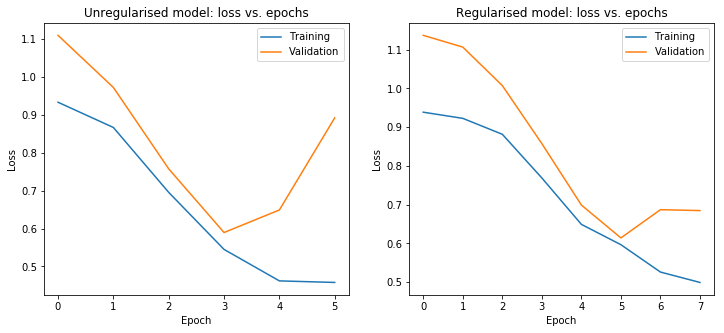

In [42]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()